In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../Dataset/HPG.csv')
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df.set_index("date", inplace=True)
series = df["close"]
""

''

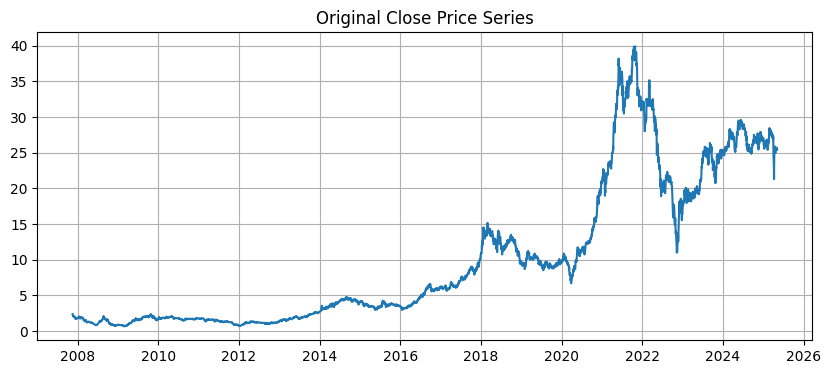

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.title("Original Close Price Series")
plt.grid(True)
plt.show()

In [4]:
adf_result = adfuller(series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -0.8820268518048768
p-value: 0.7938335996205055
Critical Values: {'1%': np.float64(-3.431864627292699), '5%': np.float64(-2.8622092782958526), '10%': np.float64(-2.567126261627658)}



After 1st differencing:
ADF Statistic: -10.688740670012335
p-value: 3.773664488071385e-19
Critical Values: {'1%': np.float64(-3.4318649781908066), '5%': np.float64(-2.862209433310026), '10%': np.float64(-2.567126344149579)}


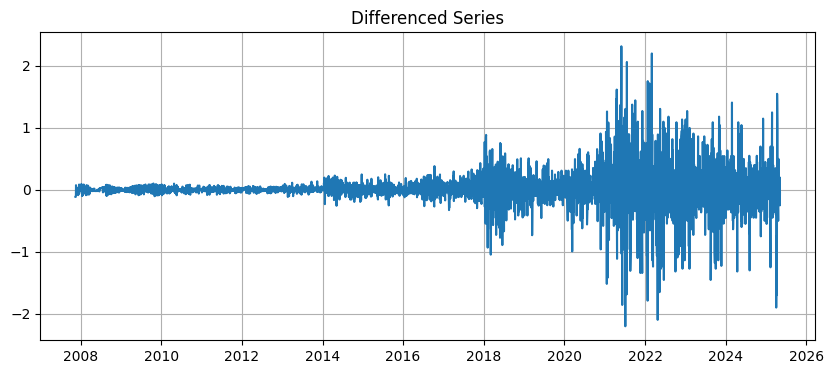

In [5]:
d = 0
if adf_result[1] > 0.05:
    d = 1
    series_diff = series.diff().dropna()
    adf_diff_result = adfuller(series_diff)
    print("\nAfter 1st differencing:")
    print("ADF Statistic:", adf_diff_result[0])
    print("p-value:", adf_diff_result[1])
    print("Critical Values:", adf_diff_result[4])

    # Plot differenced series
    plt.figure(figsize=(10, 4))
    plt.plot(series_diff)
    plt.title("Differenced Series")
    plt.grid(True)
    plt.show()
else:
    series_diff = series

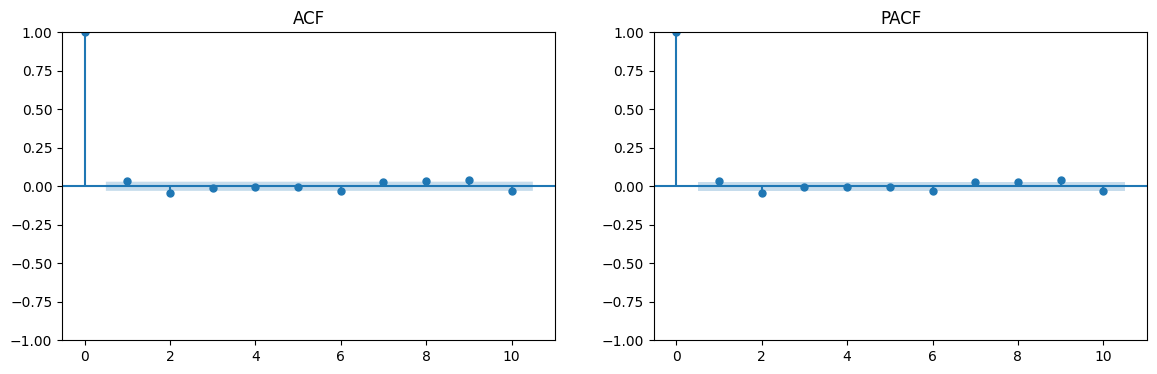

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(series_diff, ax=axes[0], lags=10)
plot_pacf(series_diff, ax=axes[1], lags=10)
axes[0].set_title("ACF")
axes[1].set_title("PACF")
plt.show()

In [7]:
best_aic = float("inf")
best_bic = float("inf")
best_avg = float("inf")
best_rmse = float("inf")
best_order = None
results_table = []


for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(series, order=(p, d, q)).fit()
            aic = model.aic
            bic = model.bic
            avg = (aic + bic) / 2

            fitted = model.fittedvalues
            actual = series[d:]
            fitted = fitted[:len(actual)]
            rmse = np.sqrt(mean_squared_error(actual, fitted))

            results_table.append((p, d, q, aic, bic, avg, rmse))

            if avg < best_avg:
                best_aic = aic
                best_bic = bic
                best_avg = avg
                best_rmse = rmse
                best_order = (p, d, q)
        except:
            continue





In [8]:
print(f"Best ARIMA Order: {best_order}")
print(f"AIC: {best_aic:.2f}, BIC: {best_bic:.2f}, AVG: {best_avg:.2f}, RMSE: {best_rmse:.4f}")

results_df = pd.DataFrame(results_table, columns=["p", "d", "q", "AIC", "BIC", "AVG(AIC/BIC)", "RMSE"])
results_df = results_df.sort_values(by="AVG(AIC/BIC)")
display(results_df.head(10))

Best ARIMA Order: (1, 1, 1)
AIC: 1624.97, BIC: 1644.10, AVG: 1634.54, RMSE: 0.4221


,p,d,q,AIC,BIC,AVG(AIC/BIC),RMSE
5,1,1,1,1624.969904,1644.104387,1634.537145,0.422118
8,2,1,0,1627.905882,1647.040365,1637.473123,0.421814
2,0,1,2,1628.090163,1647.224646,1637.657405,0.421815
1,0,1,1,1633.051084,1645.807406,1639.429245,0.422078
4,1,1,0,1633.575712,1646.332034,1639.953873,0.422067
0,0,1,0,1637.463576,1643.841737,1640.652657,0.421902
7,1,1,3,1625.646737,1657.537542,1641.592139,0.421987
6,1,1,2,1629.574961,1655.087605,1642.331283,0.421796
3,0,1,3,1629.631135,1655.143779,1642.387457,0.421798
9,2,1,1,1629.638310,1655.150954,1642.394632,0.421801


### MULTISTEP


In [9]:
forecast_results = {}
forecast_steps = [1, 30, 60]
for forecast_step in forecast_steps:
    train = series[:-forecast_step]
    test = series[-forecast_step:]
    best_model = ARIMA(train, order=best_order).fit()
    forecast = best_model.forecast(steps=forecast_step)
    future_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_step, freq='B')
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)

    forecast_results[forecast_step] = {
        'mae': mae,
        'mse': mse,
        'test': test,
        'forecast': forecast
    }
    print(f"MAE({forecast_step} steps) : {mae}")
    print(f"MSE({forecast_step} steps): {mse}")

MAE(1 steps) : 0.04121884069639492
MSE(1 steps): 0.0016989928283547822
MAE(30 steps) : 1.6041231052894582
MSE(30 steps): 4.404396574056933
MAE(60 steps) : 1.1391465847073172
MSE(60 steps): 2.1663462454682594


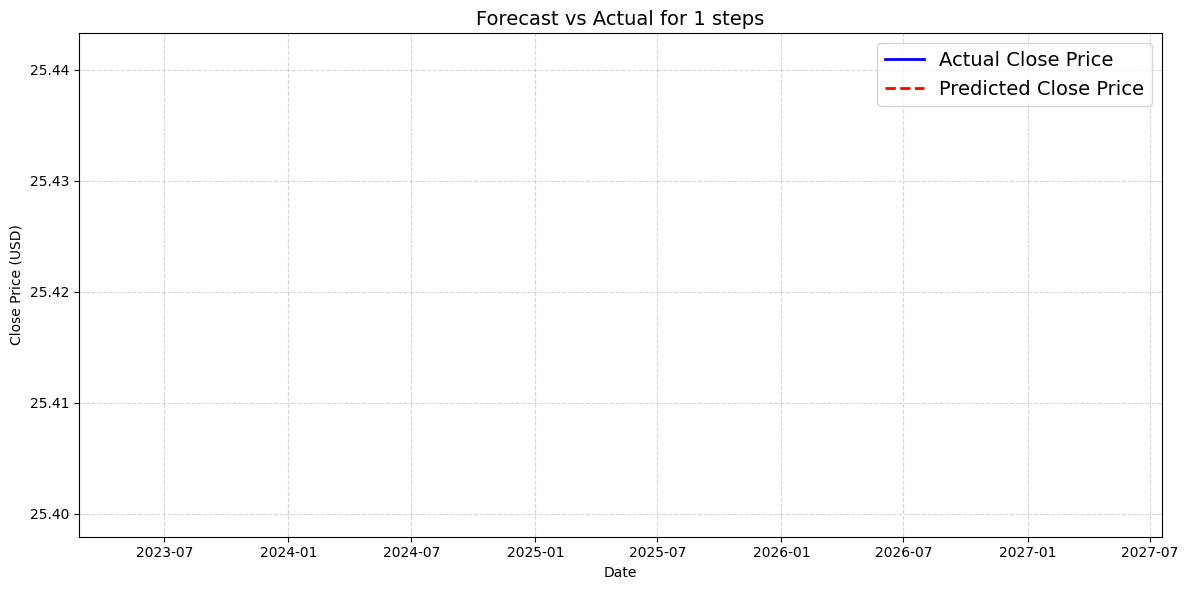

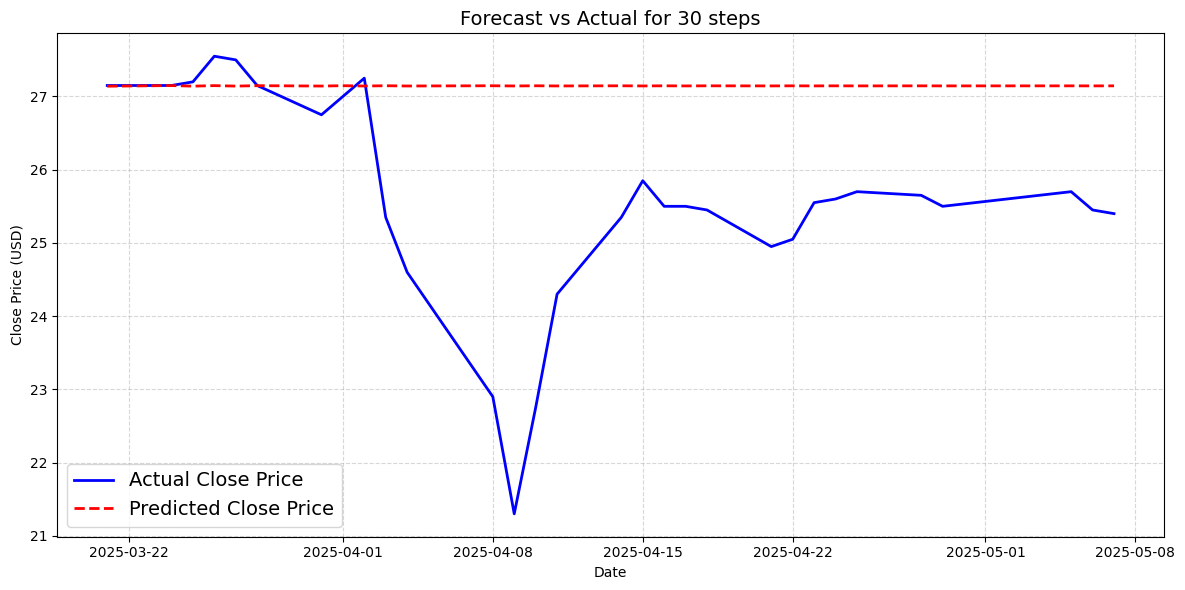

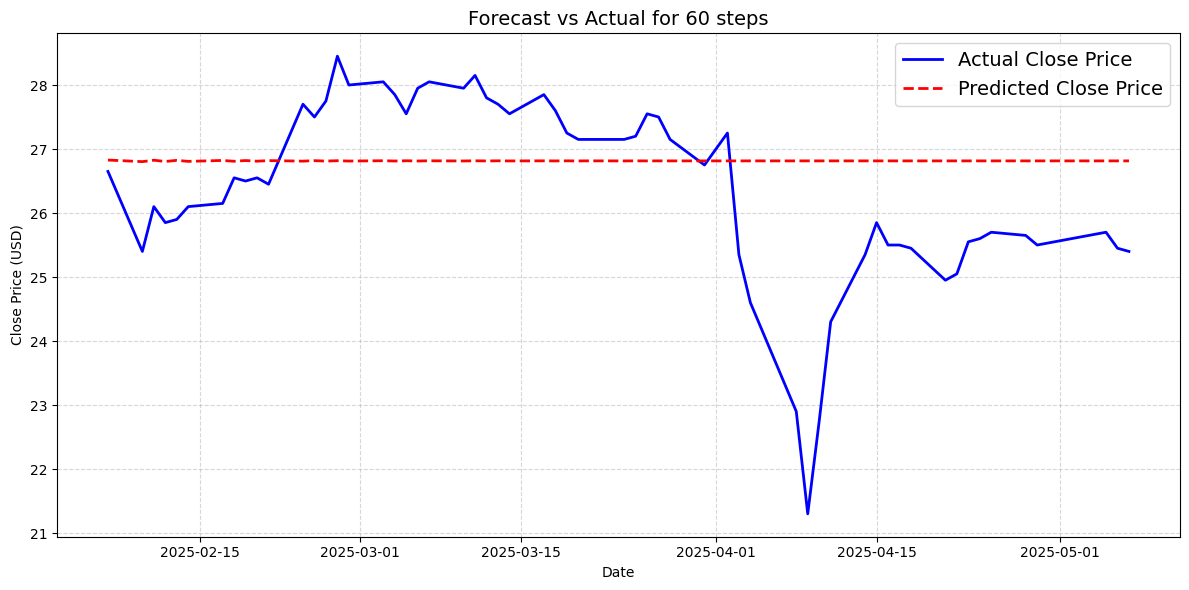

In [10]:
for step in forecast_steps:
    test = forecast_results[step]['test']
    forecast = forecast_results[step]['forecast']
    
    # Đồng bộ chỉ số ngày
    forecast.index = test.index

    plt.figure(figsize=(12, 6))
    
    # Actual close price
    plt.plot(test.index, test, color='blue', linewidth=2, label='Actual Close Price')
    
    # Forecasted close price
    plt.plot(forecast.index, forecast, color='red', linestyle='--', linewidth=2, label='Predicted Close Price')

    # Formatting
    plt.title(f"Forecast vs Actual for {step} steps", fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price (USD)', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


### ONESTEP

In [11]:
forecast_results_recursive = {}
forecast_steps = [1, 30, 60]

for step in forecast_steps:
    train = series[:-step]
    test = series[-step:]
    
    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]  # One-step forecast
        predictions.append(yhat)
        history.append(test.iloc[t])  # update with actual value

    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)

    forecast_results_recursive[step] = {
        'mae': mae,
        'mse': mse,
        'test': test,
        'forecast': pd.Series(predictions, index=test.index)
    }

    print(f"[Recursive] MAE({step} steps): {mae:.4f}")
    print(f"[Recursive] MSE({step} steps): {mse:.4f}")

[Recursive] MAE(1 steps): 0.0412
[Recursive] MSE(1 steps): 0.0017
[Recursive] MAE(30 steps): 0.4801
[Recursive] MSE(30 steps): 0.5469
[Recursive] MAE(60 steps): 0.3907
[Recursive] MSE(60 steps): 0.3635


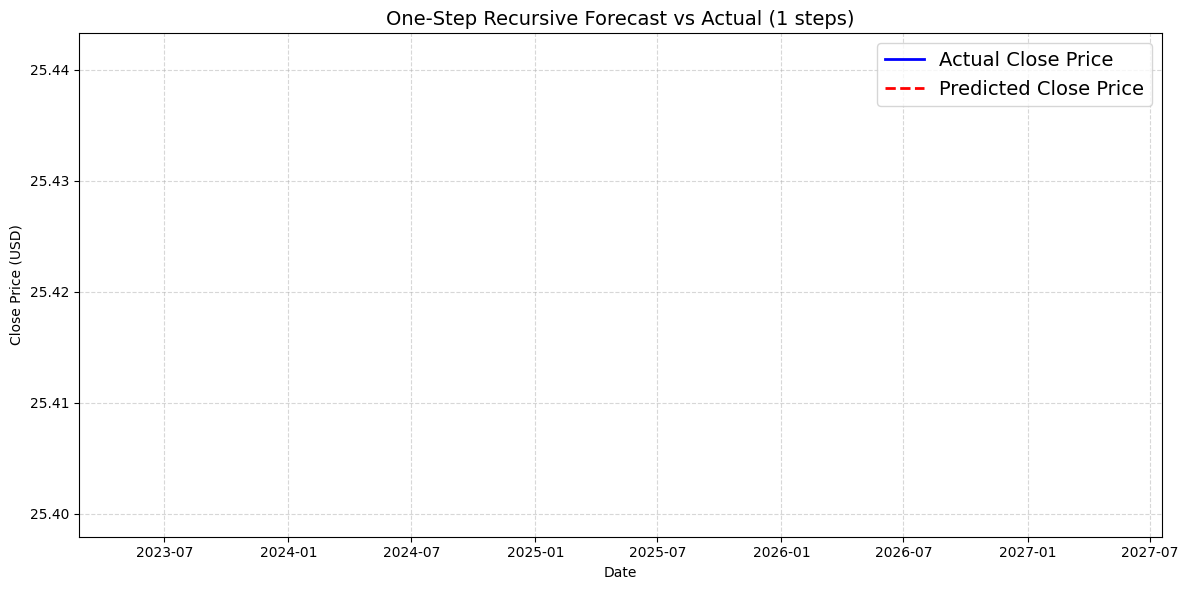

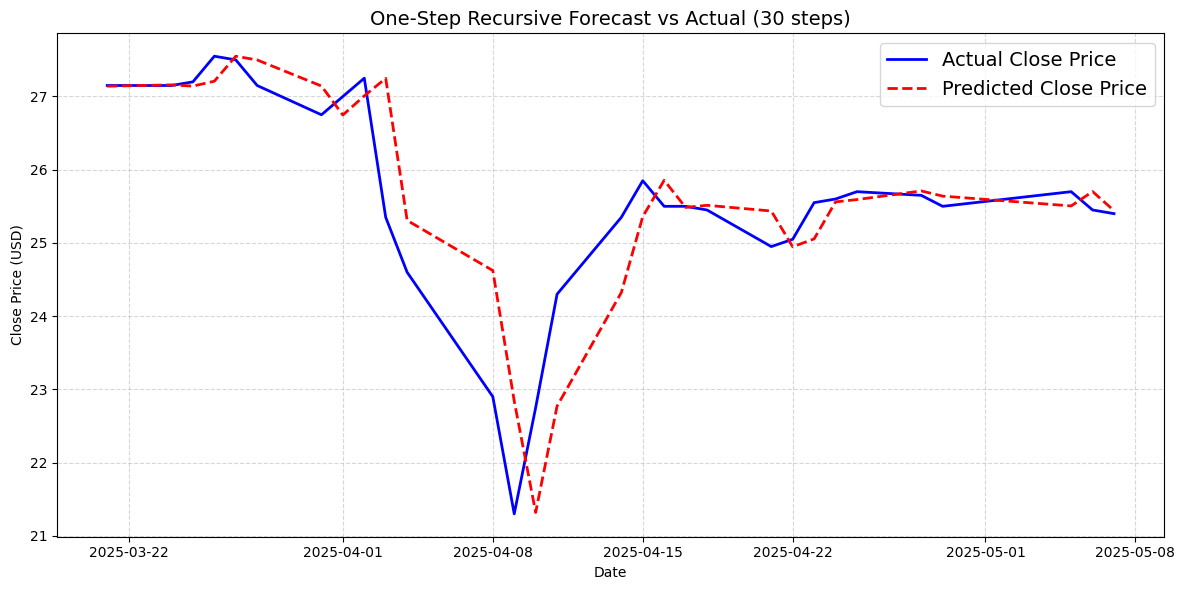

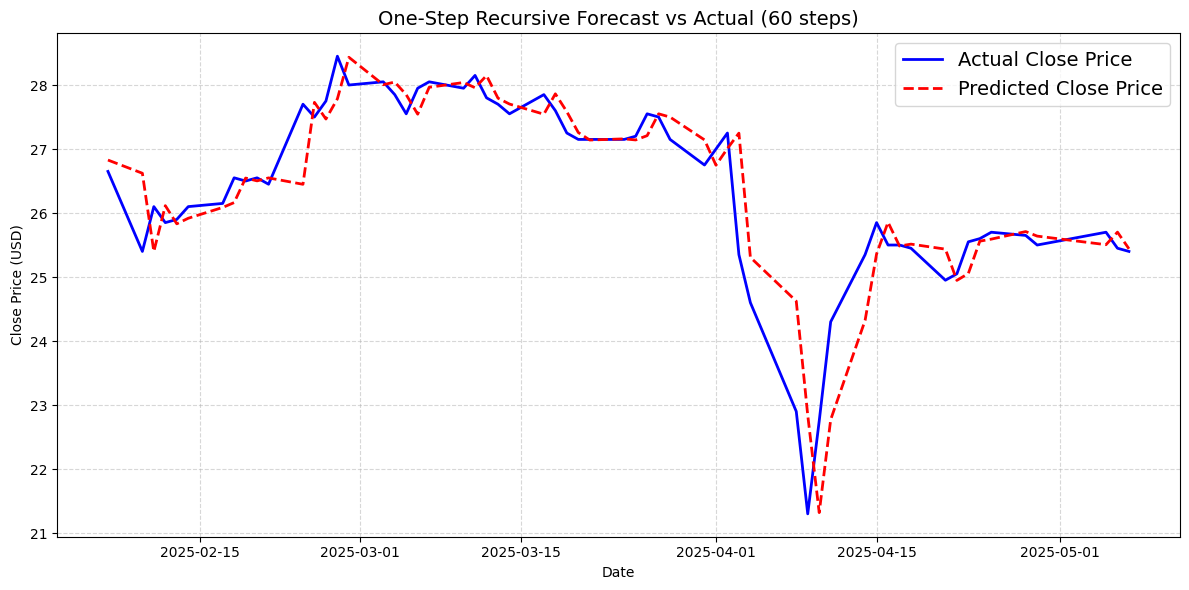

In [12]:
for step in forecast_steps:
    test = forecast_results_recursive[step]['test']
    forecast = forecast_results_recursive[step]['forecast']

    plt.figure(figsize=(12, 6))
    
    plt.plot(test.index, test, color='blue', linewidth=2, label='Actual Close Price')
    plt.plot(forecast.index, forecast, color='red', linestyle='--', linewidth=2, label='Predicted Close Price')

    plt.title(f"One-Step Recursive Forecast vs Actual ({step} steps)", fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price (USD)', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
